<a href="https://colab.research.google.com/github/aditeyabaral/Big-Data-Assignments-UE18CS322/blob/main/notebooks/Siamese_fastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [6]:
import numpy as np
import pandas as pd
import re
import string
from google.colab import files
from gensim.models import FastText
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import attention
from attention import AttentionLayer

2021-03-01 18:04:40,529 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
!curl -L -O https://raw.githubusercontent.com/aditeyabaral/abstractive-summarization/main/data/news_summary_more.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.4M  100 39.4M    0     0  22.4M      0  0:00:01  0:00:01 --:--:-- 22.4M


In [4]:
!curl -L -O https://raw.githubusercontent.com/aditeyabaral/abstractive-summarization/main/src/attention.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5230  100  5230    0     0  25763      0 --:--:-- --:--:-- --:--:-- 25763


In [5]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.49.0-cp37-none-any.whl size=19468 sha256=7e47e1fdbcb6b0d38740663455ff6154b81c374c075fb3331a5229afc57c5f4b
  Stored in directory: /root/.cache/pip/wheels/6f/9d/c5/26693a5092d9313daeae94db04818fc0a2b7a48ea381989f34
Successfully built keras-self-attention


# Reading Dataset

In [7]:
df = pd.read_csv("news_summary_more.csv")
print(df.shape)
df.head()

(98401, 2)


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# Preprocessing Data

In [8]:
def formatArticleHeader(text):
  text = text.strip().split("\n\n")
  header = text[0] + ". "
  del text[0]
  #text[0] = header + text[0]
  text = "\n\n".join(text)
  return text

In [9]:
def cleanText(text):
  contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
  text = text.lower()
  text = re.sub(" +", " ", text)
  text = re.sub("\n+", " ", text)
  text = " ".join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split()])
  return text

  # more preprocessing
  text = re.sub("[^a-zA-Z0-9\n]", " ", text)
  text = re.sub(r'\([^)]*\)', '', text)
  text = re.sub('"','', text)
  text = re.sub(r"'s\b","",text)
  return text 

In [10]:
# df["text"] = df["text"].apply(lambda x: formatArticleHeader(x))
df["text"] = df["text"].apply(lambda x: cleanText(x))
df["headlines"] = df["headlines"].apply(lambda x: "starttoken " + cleanText(x) + " endtoken")

In [11]:
df.head()

,headlines,text
0,starttoken upgrad learner switches to career i...,"saurav kant, an alumnus of upgrad and iiit-b's..."
1,starttoken delhi techie wins free food from sw...,kunal shah's credit card bill payment platform...
2,starttoken new zealand end rohit sharma-led in...,new zealand defeated india by 8 wickets in the...
3,starttoken aegon life iterm insurance plan hel...,"with aegon life iterm insurance plan, customer..."
4,"starttoken have known hirani for yrs, what if ...",speaking about the sexual harassment allegatio...


# Training fastText

In [12]:
X_words = list(map(word_tokenize, df["text"].values))
y_words = list(map(word_tokenize, df["headlines"].values))

In [14]:
ft_model_X = FastText(min_count=1)
ft_model_X.build_vocab(sentences=X_words)
ft_model_X.train(sentences=X_words, total_examples=ft_model_X.corpus_count, epochs=10)

ft_model_y = FastText(min_count=1)
ft_model_y.build_vocab(sentences=y_words)
ft_model_y.train(sentences=y_words, total_examples=ft_model_y.corpus_count, epochs=10)

2021-03-01 18:06:58,776 : INFO : collecting all words and their counts
2021-03-01 18:06:58,778 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-01 18:06:58,904 : INFO : PROGRESS: at sentence #10000, processed 680649 words, keeping 34890 word types
2021-03-01 18:06:59,034 : INFO : PROGRESS: at sentence #20000, processed 1356925 words, keeping 50069 word types
2021-03-01 18:06:59,162 : INFO : PROGRESS: at sentence #30000, processed 2028754 words, keeping 61457 word types
2021-03-01 18:06:59,285 : INFO : PROGRESS: at sentence #40000, processed 2698468 words, keeping 71022 word types
2021-03-01 18:06:59,411 : INFO : PROGRESS: at sentence #50000, processed 3363075 words, keeping 80020 word types
2021-03-01 18:06:59,548 : INFO : PROGRESS: at sentence #60000, processed 4025161 words, keeping 88497 word types
2021-03-01 18:06:59,688 : INFO : PROGRESS: at sentence #70000, processed 4688746 words, keeping 96676 word types
2021-03-01 18:06:59,821 : INFO : PROGRES

In [15]:
word2embedding_X = {word:ft_model_X.wv.get_vector(word) for word in list(ft_model_X.wv.vocab)}
word2embedding_y = {word:ft_model_y.wv.get_vector(word) for word in list(ft_model_y.wv.vocab)}

# Finding Sequence Parameters

In [16]:
X_text = df["text"].values
y_text = df["headlines"].values

In [17]:
'''Tx = len(max(X_words, key=len))
Ty = len(max(y_words, key=len))
print(f"Tx = {Tx}\nTy = {Ty}")'''

'Tx = len(max(X_words, key=len))\nTy = len(max(y_words, key=len))\nprint(f"Tx = {Tx}\nTy = {Ty}")'

In [18]:
pad_length = 100
Tx = pad_length
Ty = pad_length

tokenizer_X = Tokenizer()
tokenizer_X.fit_on_texts(list(X_text))
X_seq = tokenizer_X.texts_to_sequences(X_text)
X_seq = pad_sequences(X_seq,  maxlen=pad_length, padding='post') 
vocab_size_X = len(tokenizer_X.word_index) + 1 

tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(list(y_text))
y_seq = tokenizer_y.texts_to_sequences(y_text)
y_seq = pad_sequences(y_seq,  maxlen=pad_length, padding='post') 
vocab_size_y = len(tokenizer_y.word_index) + 1 

print(f"Vocabulary Size of X = {vocab_size_X}\nVocabulary Size of y = {vocab_size_y}")

Vocabulary Size of X = 101008
Vocabulary Size of y = 44791


In [19]:
X_seq.shape, y_seq.shape

((98401, 100), (98401, 100))

# Creating Embedding Matrices

In [20]:
embedding_matrix_X = np.zeros((vocab_size_X, 100))
for word, i in tokenizer_X.word_index.items():
	embedding_vector = word2embedding_X.get(word)
	if embedding_vector is not None:
		embedding_matrix_X[i] = embedding_vector

In [21]:
embedding_matrix_y = np.zeros((vocab_size_y, 100))
for word, i in tokenizer_y.word_index.items():
	embedding_vector = word2embedding_y.get(word)
	if embedding_vector is not None:
		embedding_matrix_y[i] = embedding_vector

# Creating Sequences

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.05, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((93480, 100), (4921, 100), (93480, 100), (4921, 100))

# Building Model

In [23]:
latent_dim = 1024

In [24]:
def cosine_distance_custom_loss_function(ignore, vector):
  vector1 = vector[:, :100:, :]
  vector2 = vector[:, 100:, :]
  return keras.losses.cosine_similarity(vector1, vector2)


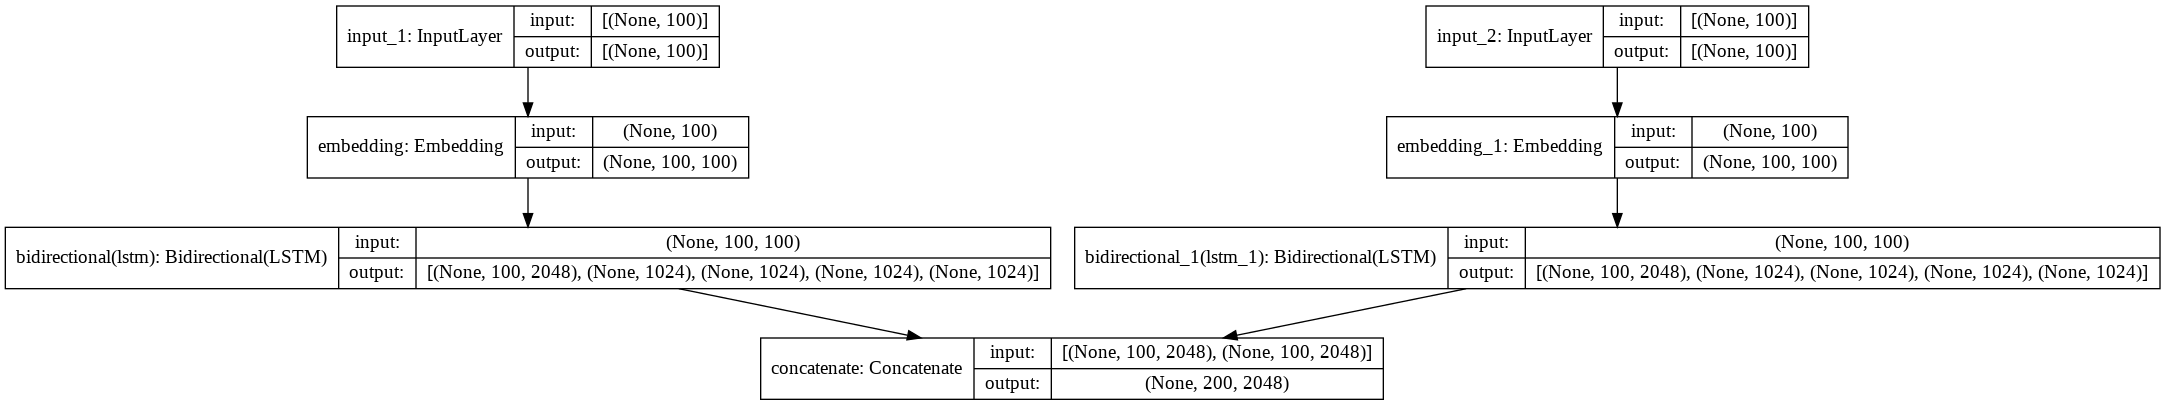

In [25]:
encoder_input_left = Input(shape=(Tx, ))
encoder_input_right = Input(shape=(Ty, ))
  
encoder_embedding_left =  Embedding(vocab_size_X, 100, weights=[embedding_matrix_X], trainable=True)(encoder_input_left)
encoder_embedding_right =  Embedding(vocab_size_y, 100, weights=[embedding_matrix_y], trainable=True)(encoder_input_right)

encoder_LSTM_left_1 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output_left, forward_h_left, forward_c_left, backward_h_left, backward_c_left = encoder_LSTM_left_1(encoder_embedding_left)

encoder_LSTM_right_1 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output_right, forward_h_right, forward_c_right, backward_h_right, backward_c_right = encoder_LSTM_right_1(encoder_embedding_right)

# self attention
# self attention

merged = Concatenate(axis=1)([encoder_output_left, encoder_output_right])

model = Model([encoder_input_left, encoder_input_right], merged)
model.compile(optimizer="adam", loss=cosine_distance_custom_loss_function)
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(
    [X_train, y_train], 
    y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],
    epochs=4,
    batch_size=128, 
    )

Epoch 1/4
  6/731 [..............................] - ETA: 8:18:30 - loss: -0.2328